In [2]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange
import os
from torchvision.datasets import ImageFolder
import tarfile

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(160),               # resize to 160×160 for imagenette2-160
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
# Paths for the Imagenette dataset (assumes you want it under ./data/imagenette2-160/)
imagenette_root = "./data/imagenette2-160"
train_dir = os.path.join(imagenette_root, "train")
val_dir   = os.path.join(imagenette_root, "val")

# download & extract if not already present
if not os.path.isdir(imagenette_root):
    os.makedirs(os.path.dirname(imagenette_root), exist_ok=True)
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    archive_path = os.path.join(os.path.dirname(imagenette_root), "imagenette2-160.tgz")
    if not os.path.exists(archive_path):
        print("Downloading Imagenette dataset...")
        import urllib.request
        urllib.request.urlretrieve(url, archive_path)
    print("Extracting Imagenette dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(imagenette_root))
    print("Done.")

# Load the Imagenette dataset
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset  = ImageFolder(val_dir,   transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

In [3]:
resnet_pretrained = models.resnet50(pretrained=True)
resnet_pretrained.fc = torch.nn.Identity()

resnet_pretrained_frozen = models.resnet50(pretrained=True)
resnet_pretrained_frozen.fc = torch.nn.Identity()

#load prior tasks
labels_list = np.load('labels_list_imagenette_1.npy')

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# ── 1. Build a “multi-label” view of the data ──────────────────────────────────
labels_matrix = np.stack(labels_list)          # (100, N)
labels_matrix = torch.from_numpy(labels_matrix).float()  # to tensor

class MultiTaskWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, all_labels):
        self.base_ds   = base_ds               # the dataset behind your test_loader
        self.all_lbls  = all_labels            # (100, N)
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        img, _    = self.base_ds[idx]
        lbl_vec   = self.all_lbls[:, idx]      # (100,)
        return img, lbl_vec

multi_ds     = MultiTaskWrapper(test_loader.dataset, labels_matrix)
multi_loader = torch.utils.data.DataLoader(multi_ds,
                                           batch_size=test_loader.batch_size,
                                           shuffle=False,
                                           num_workers=test_loader.num_workers,
                                           pin_memory=True)

# ── 2. Multi-task linear probe ─────────────────────────────────────────────────
def linear_probe_multi(model, loader, n_epoch=1):
    feat_dim   = 2048              # resnet head size
    n_tasks    = 256
    model.eval().cuda()

    head = torch.nn.Linear(feat_dim, n_tasks).cuda()
    crit = torch.nn.BCEWithLogitsLoss()
    opt  = torch.optim.Adam(head.parameters(), lr=1e-2)

    for epoch in trange(n_epoch):
        runloss = 0.
        for imgs, lbls in loader:                  # lbls → (B, 100)
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():        # mixed precision, optional
                feats   = model(imgs)              # (B, 1000)
                logits  = head(feats)              # (B, n_tasks)
                loss    = crit(logits, lbls)
            loss.backward()
            opt.step()
            runloss += loss.item()

        print(f'Epoch {epoch+1}: loss = {runloss/len(loader):.4f}')

    # ─ Evaluation per task ─
    correct = torch.zeros(n_tasks, device='cuda')
    total   = torch.zeros(n_tasks, device='cuda')

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            preds   = (head(model(imgs)) > 0).float()
            correct += (preds == lbls).sum(dim=0)
            total   += lbls.size(0)

    acc = (100*correct/total).cpu().numpy()        # shape (100,)
    print(f'Mean accuracy over 256 tasks: {acc.mean():.2f}%')
    return acc

# ── 3. Run it ──────────────────────────────────────────────────────────────────
pre_task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_110936/2703761593.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


Epoch 1: loss = 1.9752
Epoch 2: loss = 1.1820
Epoch 3: loss = 1.1743
Epoch 4: loss = 0.7158
Epoch 5: loss = 0.7031
Epoch 6: loss = 0.6229
Epoch 7: loss = 0.5906
Epoch 8: loss = 0.5252
Epoch 9: loss = 0.5080
Epoch 10: loss = 0.4892
Epoch 11: loss = 0.5268
Epoch 12: loss = 0.5884
Epoch 13: loss = 0.7207
Epoch 14: loss = 0.8511
Epoch 15: loss = 0.9048
Epoch 16: loss = 0.8571
Epoch 17: loss = 0.7955
Epoch 18: loss = 0.7426
Epoch 19: loss = 0.6879
Epoch 20: loss = 0.6662
Epoch 21: loss = 0.6447
Epoch 22: loss = 0.6529
Epoch 23: loss = 0.6759
Epoch 24: loss = 0.7220
Epoch 25: loss = 0.7671
Epoch 26: loss = 0.7709
Epoch 27: loss = 0.7688
Epoch 28: loss = 0.7388
Epoch 29: loss = 0.6976
Epoch 30: loss = 0.6854
Mean accuracy over 256 tasks: 78.26%


(array([ 2.,  2.,  2.,  2.,  3.,  3.,  5.,  6.,  4.,  4.,  4., 10., 16.,
        14., 20., 28., 43., 46., 27., 15.]),
 array([55.69426727, 57.22929764, 58.76433182, 60.29936218, 61.83439636,
        63.36942673, 64.90445709, 66.43949127, 67.97452545, 69.509552  ,
        71.04458618, 72.57962036, 74.11464691, 75.64968109, 77.18471527,
        78.71974182, 80.254776  , 81.78981018, 83.32484436, 84.85987091,
        86.39490509]),
 <BarContainer object of 20 artists>)

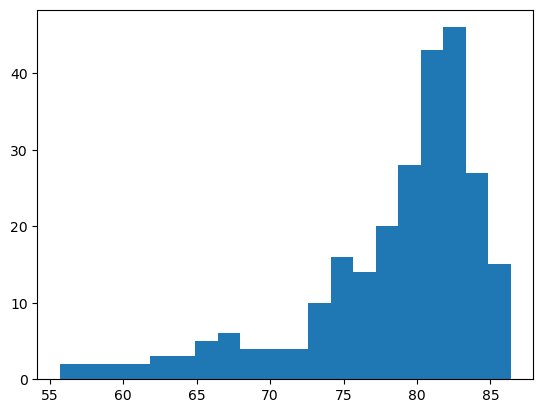

In [5]:
plt.hist(pre_task_accuracies, bins=20)

In [6]:
pre_task_accuracies

array([64.10191 , 75.51592 , 82.191086, 84.05096 , 81.98726 , 69.85987 ,
       82.72611 , 83.84714 , 77.63057 , 83.41401 , 79.388535, 77.27389 ,
       79.69427 , 81.22293 , 80.48408 , 77.605095, 83.36306 , 76.891716,
       78.26752 , 61.401276, 74.598724, 70.038216, 80.84077 , 79.66879 ,
       69.8344  , 83.13376 , 82.1656  , 82.242035, 75.388535, 81.12102 ,
       83.21019 , 82.394905, 83.592354, 83.3121  , 67.28662 , 76.50955 ,
       78.77707 , 84.968155, 81.29936 , 83.592354, 74.675156, 56.229298,
       75.13376 , 73.27389 , 78.62421 , 72.63694 , 70.52229 , 80.84077 ,
       82.34395 , 82.44586 , 74.54777 , 83.23567 , 82.52229 , 75.49045 ,
       83.94904 , 82.191086, 66.26752 , 81.324844, 80.15286 , 66.80255 ,
       68.20382 , 76.178345, 62.853504, 83.821655, 68.73885 , 75.821655,
       83.69427 , 83.94904 , 62.980892, 60.178345, 83.64331 , 66.038216,
       81.961784, 65.52866 , 83.21019 , 78.64968 , 80.891716, 73.044586,
       75.49045 , 77.91083 , 75.3121  , 83.66879 , 

In [5]:
def compute_expectation_variance(K, M, T=1.0):
    if K.shape != M.shape:
        raise ValueError("K and M must have the same shape.")

    sigma = torch.sigmoid(K / T)              # σ(K_{ij}/T)
    expectation = (M * sigma).sum()           # Σ M σ
    variance = ((M**2) * sigma * (1 - sigma)).sum()  # Σ M² σ(1−σ)

    return expectation, variance  

In [20]:
beta = 2.5
T = 1

n_epoch = 30

resnet_pretrained.train()
resnet_pretrained_frozen.eval()

optimizer = torch.optim.Adam(resnet_pretrained.parameters(), lr=0.001)

resnet_pretrained.cuda()
resnet_pretrained_frozen.cuda()

for epoch in range(n_epoch):  
    running_loss = 0.0
    running_exp = 0.0
    running_var = 0.0
    n = 0

    for images, labels in train_loader:
        images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
        images = images.cuda()

        with torch.no_grad():
            outputs = resnet_pretrained_frozen(images)

            norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
            K = norm_outputs @ norm_outputs.T
            
        outputs = resnet_pretrained(images)

        norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
        M = norm_outputs @ norm_outputs.T

        exp, var = compute_expectation_variance(K, M, T)

        loss = beta * var -  exp

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print statistics  

        running_loss += loss.item()
        running_exp += exp.item()
        running_var += var.item()

        n += 1

    print(f'Epoch {epoch+1}, Loss: {running_loss/n:.4f}, Expectation: {running_exp/n:.4f}, Variance: {running_var/n:.4f}')

Epoch 1, Loss: -720.4100, Expectation: 1499.2285, Variance: 311.5274
Epoch 2, Loss: -723.0142, Expectation: 1492.4918, Variance: 307.7911
Epoch 3, Loss: -725.2023, Expectation: 1488.2094, Variance: 305.2028
Epoch 4, Loss: -725.9827, Expectation: 1484.5977, Variance: 303.4460
Epoch 5, Loss: -726.6067, Expectation: 1483.8950, Variance: 302.9153
Epoch 6, Loss: -727.2507, Expectation: 1482.6080, Variance: 302.1429
Epoch 7, Loss: -727.5146, Expectation: 1481.3855, Variance: 301.5483
Epoch 8, Loss: -727.5281, Expectation: 1481.1018, Variance: 301.4295
Epoch 9, Loss: -727.8160, Expectation: 1480.7800, Variance: 301.1856
Epoch 10, Loss: -728.0609, Expectation: 1480.6495, Variance: 301.0354
Epoch 11, Loss: -728.3188, Expectation: 1480.7056, Variance: 300.9547
Epoch 12, Loss: -728.2812, Expectation: 1479.7477, Variance: 300.5866
Epoch 13, Loss: -728.5286, Expectation: 1479.8085, Variance: 300.5120
Epoch 14, Loss: -728.5107, Expectation: 1479.6576, Variance: 300.4588
Epoch 15, Loss: -728.5079, Ex

KeyboardInterrupt: 

In [7]:
from datetime import datetime

# Save the fine-tuned ResNet backbone with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"resnet_pretrained_finetuned_{timestamp}.pth"
torch.save(resnet_pretrained.state_dict(), filename)
print(f"Model state_dict saved to {filename} at {timestamp}")

Model state_dict saved to resnet_pretrained_finetuned_20250507_210810.pth at 20250507_210810


In [21]:
task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_92651/2703761593.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


Epoch 1: loss = 1.3618
Epoch 2: loss = 0.9724
Epoch 3: loss = 0.8950
Epoch 4: loss = 0.6560
Epoch 5: loss = 0.6302
Epoch 6: loss = 0.5640
Epoch 7: loss = 0.5634
Epoch 8: loss = 0.5321
Epoch 9: loss = 0.5304
Epoch 10: loss = 0.5178
Epoch 11: loss = 0.5165
Epoch 12: loss = 0.5193
Epoch 13: loss = 0.5274
Epoch 14: loss = 0.5366
Epoch 15: loss = 0.5426
Epoch 16: loss = 0.5438
Epoch 17: loss = 0.5517
Epoch 18: loss = 0.5584
Epoch 19: loss = 0.5603
Epoch 20: loss = 0.5561
Epoch 21: loss = 0.5441
Epoch 22: loss = 0.5447
Epoch 23: loss = 0.5458
Epoch 24: loss = 0.5525
Epoch 25: loss = 0.5569
Epoch 26: loss = 0.5606
Epoch 27: loss = 0.5596
Epoch 28: loss = 0.5562
Epoch 29: loss = 0.5520
Epoch 30: loss = 0.5589
Mean accuracy over 256 tasks: 77.59%


In [22]:
variance = np.var(task_accuracies)
old_var = np.var(pre_task_accuracies)
print(f"Variance before: {old_var}")
print(f"Variance after: {variance}")

Variance before: 34.394126892089844
Variance after: 12.694658279418945


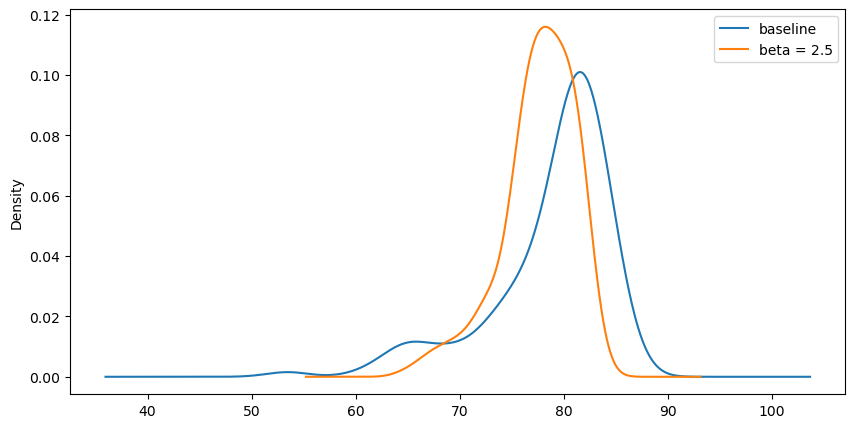

In [25]:
import pandas as pd
plt.figure(figsize=(10, 5))
pd.Series(pre_task_accuracies).plot.kde(label='baseline')
pd.Series(task_accuracies).plot.kde(label='beta = 2.5')

plt.legend()

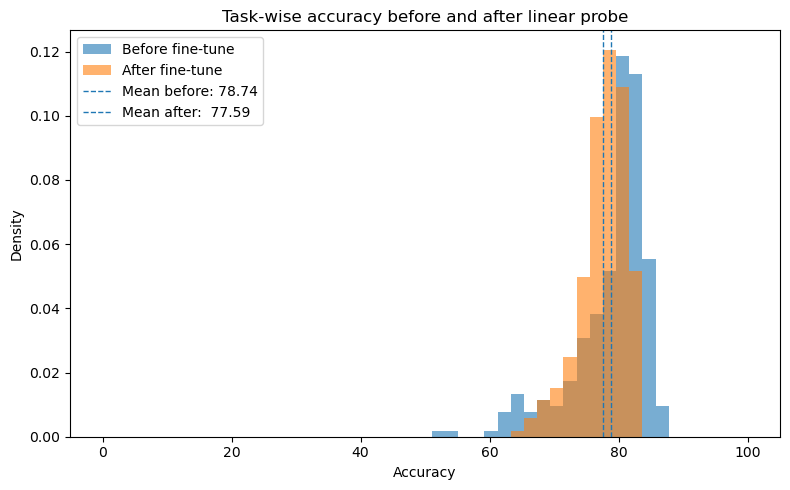

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# ── use identical bin edges so the bars line up ──
bins = np.linspace(0, 100, 50)              # 0 – 1 in 5-point steps

plt.hist(pre_task_accuracies, bins=bins,
         alpha=0.6, density=True,
         label='Before fine-tune')

plt.hist(task_accuracies,     bins=bins,
         alpha=0.6, density=True,
         label='After fine-tune')

# ── mark the means ──
plt.axvline(np.mean(pre_task_accuracies),  linestyle='--', linewidth=1,
            label=f"Mean before: {np.mean(pre_task_accuracies):.2f}")
plt.axvline(np.mean(task_accuracies),      linestyle='--', linewidth=1,
            label=f"Mean after:  {np.mean(task_accuracies):.2f}")

plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Task-wise accuracy before and after linear probe')
plt.legend()
plt.tight_layout()
plt.show()